# TD2 : Circuits nerveux générateurs de rythmes (CPG)

# I. Le neurone Rowat-Selverston (RS)

𝜏𝑚 est la constante de temps de la membrane.

𝜏𝑠 est la constante de temps du courant lent I_slow. On a toujours 𝜏𝑠 < 𝜏𝑚.

𝐴𝑓 permet de modifier la largeur de la forme en N de I_fast, sans en modifier le degré.

𝜎𝑓, au contraire, permet de modifier le degré de la forme en N de I_fast. (1-𝜎𝑓) est la pente à l'origine de la courbe I-V.
- Lorsque 𝜎𝑓 = 0, la courbe I-V a une asymptote horizontale à l'origine.
- Lorsque 0 < 𝜎𝑓 <= 1,  la courbe a un point d'inflexion à l'origine.
- Lorsque 𝜎𝑓 > 1, la courbe a une forme en N.

𝜎𝑠 est le gain des courants intérieur et extérieur qui composent l'asymptote à l'infini de I_slow.

In [1]:
from math import tanh
import matplotlib.pyplot as plt
import uuid

# Paramètres de simulation
dt = 0.05  # pas de temps en ms
Is = 6.0  # courant de stimulation en uA
T = 1000.0 # temps de simulation en ms

class NeuronRS():
    def __init__(self, taum, taus, Af, sigmaf, sigmas):
        self.id = uuid.uuid4() #identifiant du neurone
        self.Vm = -65. #potentiel membranaire en mV
        self.q = 0. #courant lent en µA
        self.t = 0. #instant
        #Paramètres du modèle
        self.taum = taum #constante de temps membrane en ms
        self.taus = taus #constante de temps Islow en ms
        self.Af = Af #amplitude courant rapide en µA
        self.sigmaf = sigmaf #pente courant rapide
        self.sigmas = sigmas #pente courant lent
        # Variables monitorées
        self.l_spike_t = []       # temps en ms dont les impulsions se produisent 
        self.l_Vm = []            # valeurs du potentiel membranaire en mV
        self.l_Is = []            # valeurs de courants de stimulation en µA   
    def step(self, Is):
        Ifast = self.Vm - self.Af*tanh((self.sigmaf/self.Af) * self.Vm) #courant rapide en mV
        Islow = self.q #courant lent en mV
        dVm = (Is - Ifast - Islow)/self.taum
        dq = (self.q + self.sigmas*self.Vm)/self.taus
        Vm_passe = self.Vm
        self.Vm = self.Vm + dVm*dt
        self.q = self.q + dq*dt
        if self.Vm >= -50 and Vm_passe < -50:
            self.l_spike_t.append(self.t)
        self.t += dt
    def simulation(self):
        for i in range(int(T/dt)) :
            self.l_Vm.append(self.Vm)
            self.l_Is.append(Is)
            self.step(Is)
    def affichage(self):
        times = [i*dt for i in range(int(T/dt))]    
        plt.figure(1, figsize=(10,5))
        plt.plot(times, self.l_Vm)
        plt.ylabel("Potentiel membranaire (mV)")
        plt.xlabel("Temps (ms)")
        plt.figure(2, figsize=(10,5))
        plt.plot(times, self.l_Is)
        plt.ylabel("Courant de stimulation (µA)")
        plt.xlabel("Temps (ms)")
        plt.show()

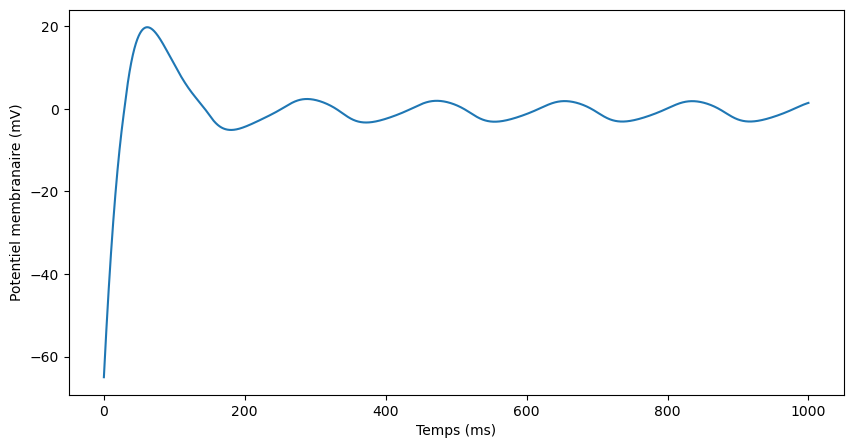

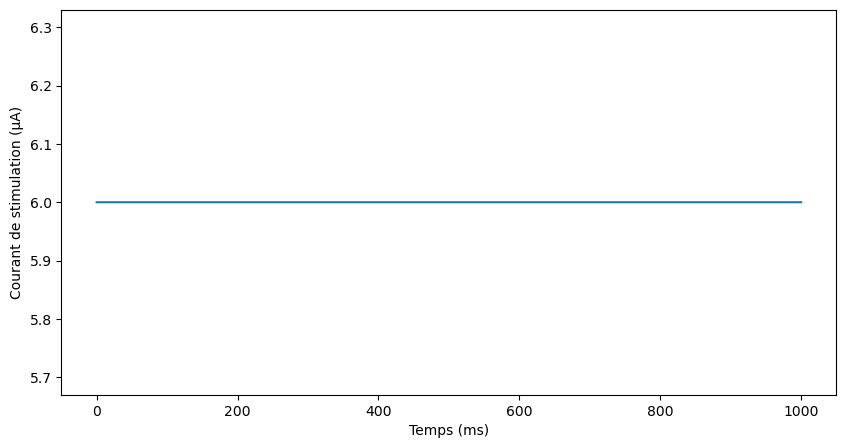

In [2]:
# Endogenous bursting

Neuron_endo_bursting = NeuronRS(20., 400., 2.8, 1.25, 10.)
Neuron_endo_bursting.simulation()
Neuron_endo_bursting.affichage()

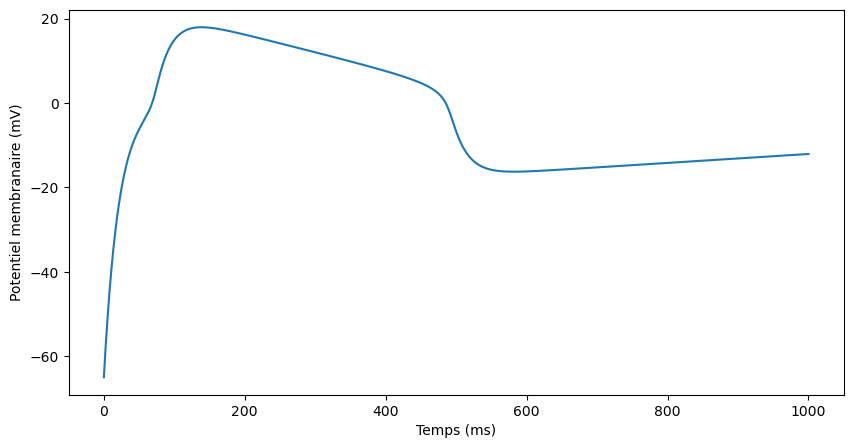

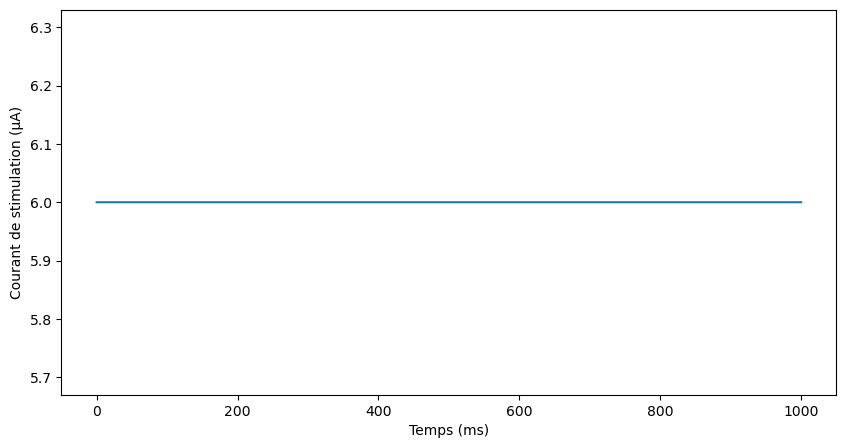

In [3]:
# Plateau potentials

Neuron_plateau = NeuronRS(20., 400., 10., 2.5, 1.)
Neuron_plateau.simulation()
Neuron_plateau.affichage()

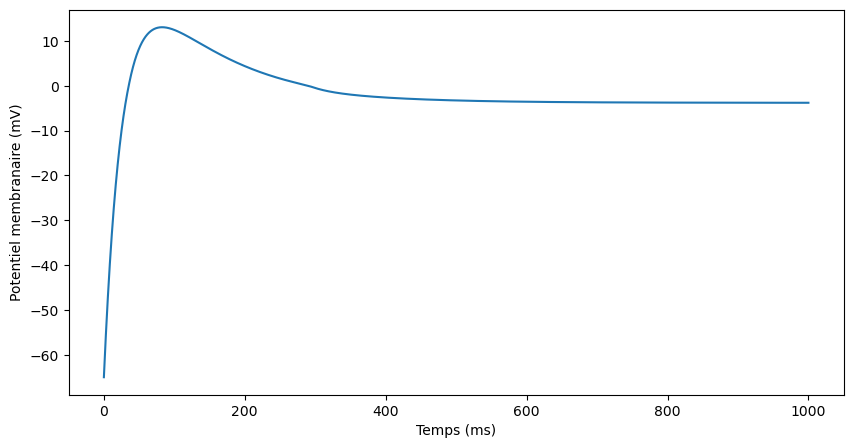

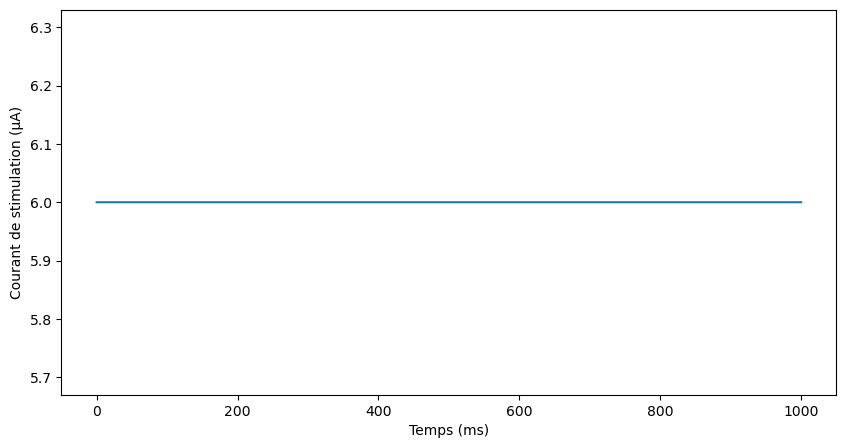

In [4]:
# Post-inhibitory rebound

Neuron_pir = NeuronRS(20., 250., 0.3, 1.3, 2.5)
Neuron_pir.simulation()
Neuron_pir.affichage()

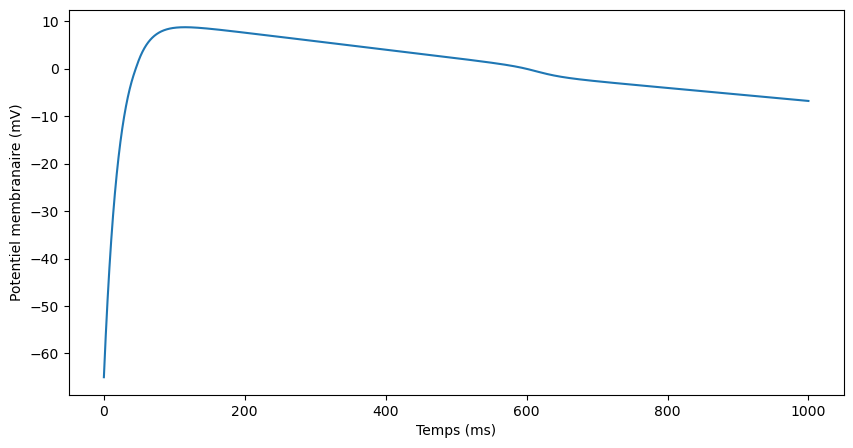

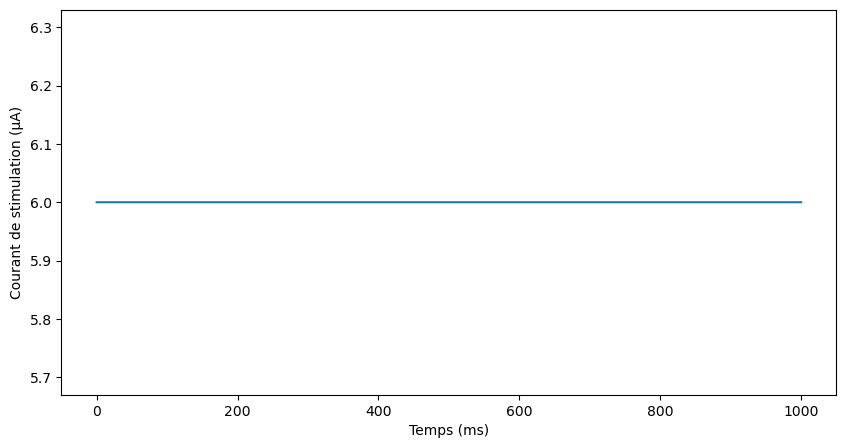

In [5]:
# Spike-frequency adaptation

Neuron_pir = NeuronRS(20., 400., 0.8, 0.8, 1.)
Neuron_pir.simulation()
Neuron_pir.affichage()

# II. Etude de la synchronisation via synapses

In [6]:
# Paramètres de simulation
dt = 0.05  # pas de temps en ms
T = 100.0 # temps de simulation en ms

In [137]:
class NeuronRS2():
    def __init__(self, Vm0, taum, taus, Af, sigmaf, sigmas, name):
        self.name = name #identifiant du neurone
        self.Vm = Vm0 #potentiel membranaire en mV. -65 dans le tp précédent
        self.q = 0. #courant lent en µA
        self.t = 0. #instant
        #Paramètres du modèle
        self.taum = taum #constante de temps membrane en ms
        self.taus = taus #constante de temps Islow en ms
        self.Af = Af #amplitude courant rapide en µA
        self.sigmaf = sigmaf #pente courant rapide
        self.sigmas = sigmas #pente courant lent
        # Variables monitorées
        self.l_spike_t = []       # temps en ms dont les impulsions se produisent 
        self.l_Vm = []            # valeurs du potentiel membranaire en mV
        self.l_Is = []            # valeurs de courants de stimulation en µA   
        # Ajout du neurone dans dic_neurones
        dic_neurones[self.name] = self
    def courant_synapses_elec(self):
        # Courant de synapses électriques en mV
        Iej_res = 0 
        for synapse in dic_syn.values():
            if self.name in synapse.neuron_name_list:
                for n_name in synapse.neuron_name_list:
                    if n_name != self.name:
                        connected_neuron = dic_neurones[n_name]
                        Iej_res += (synapse.g_ej*(connected_neuron.Vm - self.Vm))
        return Iej_res
    def step(self, Is):
        Ifast = self.Vm - self.Af*tanh((self.sigmaf/self.Af) * self.Vm) #courant rapide en mV
        Islow = self.q #courant lent en mV
        Iej = self.courant_synapses_elec() # Courant de synapses électriques en mV
        dVm = (Is  + Iej - Ifast - Islow)/self.taum
        dq = (self.q + self.sigmas*self.Vm)/self.taus
        Vm_passe = self.Vm
        self.Vm = self.Vm + dVm*dt
        self.q = self.q + dq*dt
        if self.Vm >= -50 and Vm_passe < -50:
            self.l_spike_t.append(self.t)
        self.t += dt
    def simulation(self, Is_list):
        for i in range(int(T/dt)) :
            Is = Is_list[int(self.t/dt)]
            self.l_Vm.append(self.Vm)
            self.l_Is.append(Is)
            self.step(Is)
    def affichage(self):
        times = [i*dt for i in range(int(T/dt))]    
        plt.figure(1, figsize=(10,5))
        plt.plot(times, self.l_Vm)
        plt.ylabel("Potentiel membranaire (mV)")
        plt.xlabel("Temps (ms)")
        plt.figure(2, figsize=(10,5))
        plt.plot(times, self.l_Is)
        plt.ylabel("Courant de stimulation (µA)")
        plt.xlabel("Temps (ms)")
        plt.show()

class Synapse():
    def __init__(self, E_syn_i, neuron_name_list):
        self.E = E_syn_i # V
        self.g_ej = 0.5*1e-3 # conductance de jonction électrique en S
        self.neuron_name_list = neuron_name_list
        self.id = uuid.uuid4() #identifiant de la synapse
        # Ajout de la synapse dans dic_syn et dans les listes de synapses de first_neuron et second_neuron
        dic_syn[self.id] = self

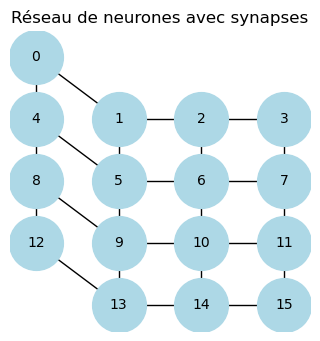

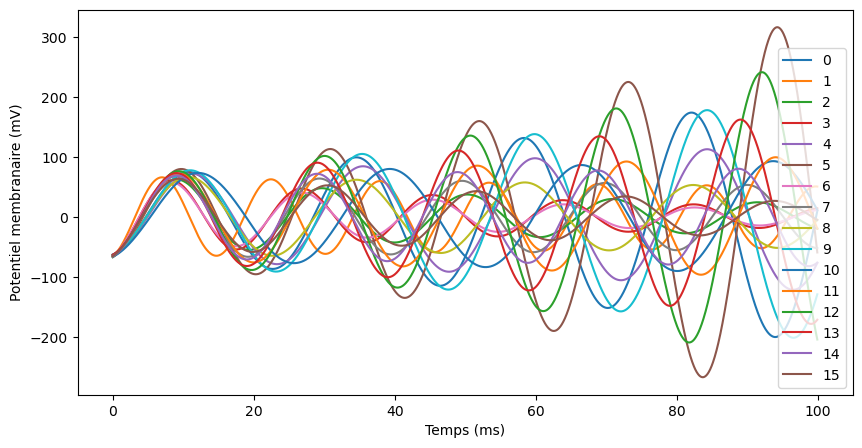

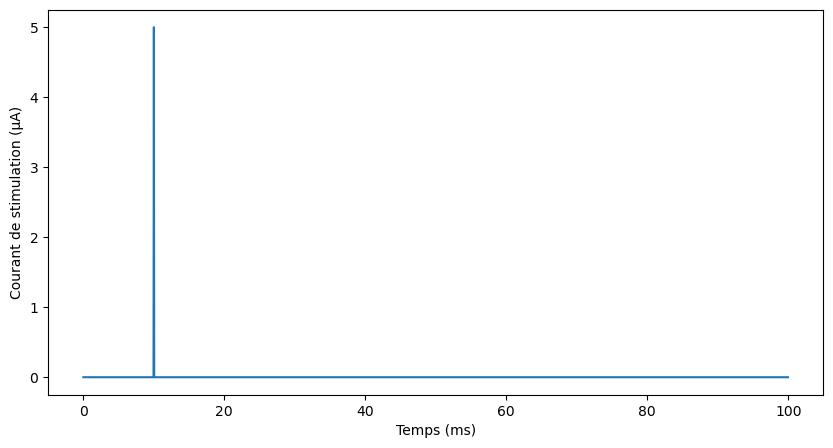

In [145]:
# ESSAI AVEC DES SYNAPSES INHIBITRICES

import networkx as nx
import numpy as np

dic_syn = {}
dic_neurones = {}

# Paramètres moyens des neurones
taum = 10.
taus = 10.
Af = 2.5
sigmaf = 1.
sigmas = 10.

# Construction des neurones
for i in range(16):
    name = f"{i}"
    Vm0 = -65 + np.random.normal(0, 1.5)  # mV
    taum_bruite = taum + np.random.normal(0, 1.5)
    taus_bruite = taus + np.random.normal(0, 1.5)
    Af_bruite = Af + np.random.normal(0, 1.5)
    sigmaf_bruite = sigmaf + np.random.normal(0, 1.5)
    sigmas_bruite = sigmas + np.random.normal(0, 1.5)
    neuron = NeuronRS2(Vm0, taum_bruite, taus_bruite, Af_bruite, sigmaf_bruite, sigmas_bruite, name)

# Paramètres des synapses
E_syn_i = -70 # en mV. -70 pour une synapse inhibitrice. 0 pour une excitatrice

# Construction des synapses
# En lignes
for i in range(4):
    for j in range(3):
        synapse = Synapse(E_syn_i, [f"{4*i+j}", f"{4*i+j+1}"])
# En colonnes
for j in range(4):
    for i in range(3):
        synapse = Synapse(E_syn_i, [f"{j+4*i}", f"{j+4*(i+1)}"])

# Affichage graphe
G = nx.Graph() 
pos = {}
# Ajout des neurones
for neuron_name in dic_neurones:
    G.add_node(neuron_name, label=neuron_name)
    pos[neuron_name] = (int(neuron_name)%4, -int(neuron_name)//4)
# Ajout des synapses
for syn in dic_syn.values():
    G.add_edge(syn.neuron_name_list[0], syn.neuron_name_list[1])
# Labels des neurones
labels = {n: G.nodes[n]["label"] for n in G.nodes}
# Dessin
plt.figure(figsize=(3, 3))
nx.draw(
    G, pos,
    with_labels=False,
    node_size=1500,
    node_color="lightblue",
    edge_color="black"
)
nx.draw_networkx_labels(G, pos, labels, font_size=10)
plt.title("Réseau de neurones avec synapses")
plt.axis("off")
plt.show()

# Boucle de simulation sur les neurones connectés

# Courant de stimulation en uA : dirac
Is = [0 for i in range(int(T/dt))]
Is[200] = 5. # en µA
Is_vide = [0 for i in range(int(T/dt))]

plt.figure(1, figsize=(10,5))
times = [i*dt for i in range(int(T/dt))]    
for neurone in dic_neurones.values():
    if neurone.name == "0":
        neurone.simulation(Is)
    else:
        neurone.simulation(Is_vide)
    plt.plot(times, neurone.l_Vm, label=neurone.name)
    plt.ylabel("Potentiel membranaire (mV)")
    plt.xlabel("Temps (ms)")
    plt.legend()
plt.figure(2, figsize=(10,5))
plt.plot(times, Is)
plt.ylabel("Courant de stimulation (µA)")
plt.xlabel("Temps (ms)")
plt.show()

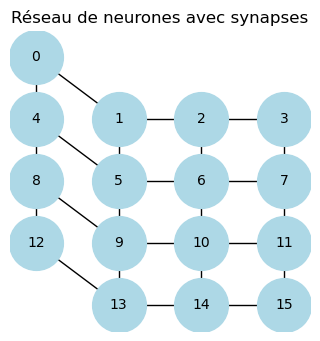

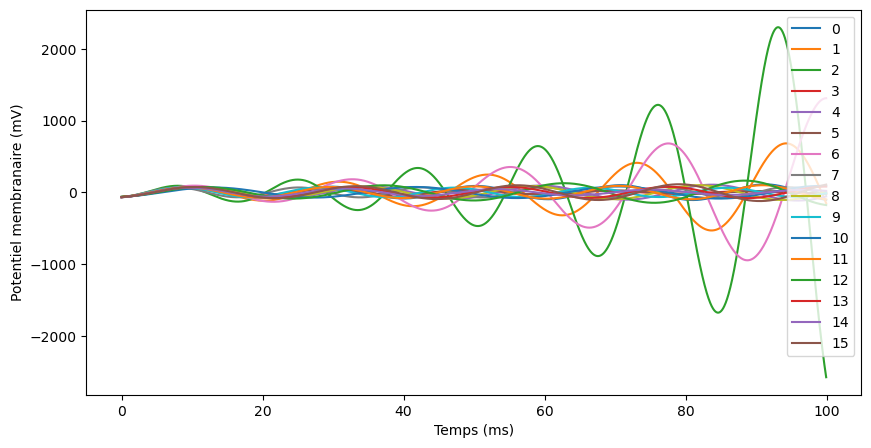

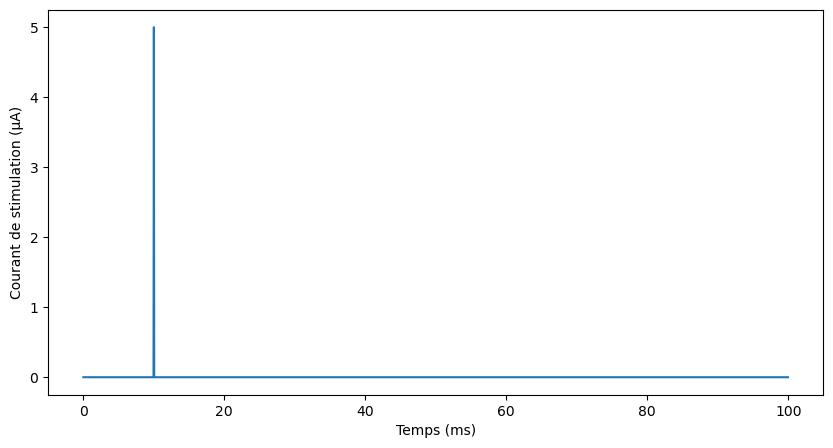

In [146]:
# ESSAI AVEC DES SYNAPSES EXCITATRICES

# Paramètres de simulation
dt = 0.05  # pas de temps en ms
T = 100.0 # temps de simulation en ms

dic_syn = {}
dic_neurones = {}

# Paramètres moyens des neurones
taum = 10.
taus = 10.
Af = 2.5
sigmaf = 1.
sigmas = 10.

# Construction des neurones
for i in range(16):
    name = f"{i}"
    Vm0 = -65 + np.random.normal(0, 1.5)  # mV
    taum_bruite = taum + np.random.normal(0, 1.5)
    taus_bruite = taus + np.random.normal(0, 1.5)
    Af_bruite = Af + np.random.normal(0, 1.5)
    sigmaf_bruite = sigmaf + np.random.normal(0, 1.5)
    sigmas_bruite = sigmas + np.random.normal(0, 1.5)
    neuron = NeuronRS2(Vm0, taum_bruite, taus_bruite, Af_bruite, sigmaf_bruite, sigmas_bruite, name)

# Paramètres des synapses
E_syn_i = 0. # en mV. -70 pour une synapse inhibitrice. 0 pour une excitatrice

# Construction des synapses
# En lignes
for i in range(4):
    for j in range(3):
        synapse = Synapse(E_syn_i, [f"{4*i+j}", f"{4*i+j+1}"])
# En colonnes
for j in range(4):
    for i in range(3):
        synapse = Synapse(E_syn_i, [f"{j+4*i}", f"{j+4*(i+1)}"])

# Affichage graphe
G = nx.Graph() 
pos = {}
# Ajout des neurones
for neuron_name in dic_neurones:
    G.add_node(neuron_name, label=neuron_name)
    pos[neuron_name] = (int(neuron_name)%4, -int(neuron_name)//4)
# Ajout des synapses
for syn in dic_syn.values():
    G.add_edge(syn.neuron_name_list[0], syn.neuron_name_list[1])
# Labels des neurones
labels = {n: G.nodes[n]["label"] for n in G.nodes}
# Dessin
plt.figure(figsize=(3, 3))
nx.draw(
    G, pos,
    with_labels=False,
    node_size=1500,
    node_color="lightblue",
    edge_color="black"
)
nx.draw_networkx_labels(G, pos, labels, font_size=10)
plt.title("Réseau de neurones avec synapses")
plt.axis("off")
plt.show()

# Boucle de simulation sur les neurones connectés

# Courant de stimulation en uA : dirac
Is = [0 for i in range(int(T/dt))]
Is[200] = 5. # en µA
Is_vide = [0 for i in range(int(T/dt))]

plt.figure(1, figsize=(10,5))
times = [i*dt for i in range(int(T/dt))]    
for neurone in dic_neurones.values():
    if neurone.name == "0":
        neurone.simulation(Is)
    else:
        neurone.simulation(Is_vide)
    plt.plot(times, neurone.l_Vm, label=neurone.name)
    plt.ylabel("Potentiel membranaire (mV)")
    plt.xlabel("Temps (ms)")
    plt.legend()
plt.figure(2, figsize=(10,5))
plt.plot(times, Is)
plt.ylabel("Courant de stimulation (µA)")
plt.xlabel("Temps (ms)")
plt.show()

On constate une divergence des oscillations. La synchronisation des neurones se fait peut-être sur une échelle de temps plus longue.